<a href="https://colab.research.google.com/github/Taller88/StockPricePredict/blob/master/SamsungStockPrice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded=files.upload()#파일업로드 기능 실행

for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length}bytes'.format(name=fn, length=len(uploaded[fn])))

Saving samsung.csv to samsung (1).csv
User uploaded file "samsung.csv" with length 360318bytes


In [ ]:
import pandas as pd 
import io

df_price=pd.read_csv(io.StringIO(uploaded['samsung.csv'].decode('utf-8')))

In [ ]:
model_path=os.path.abspath(uploaded['samsung.csv'])

In [ ]:
print(df_price)

            일자     시가     고가     저가     종가       거래량
0     20200107  55700  56400  55600  55800   9893846
1     20200106  54900  55600  54600  55500  10278951
2     20200103  56000  56600  54900  55500  15422255
3     20200102  55500  56000  55000  55200  12993228
4     20191230  56200  56600  55700  55800   8356767
...        ...    ...    ...    ...    ...       ...
9283  19850109    126    126    122    123    324836
9284  19850108    129    129    127    127    845098
9285  19850107    129    130    128    129    771895
9286  19850105    129    129    128    128    108496
9287  19850104    130    130    129    129    111764

[9288 rows x 6 columns]


In [ ]:
pd.to_datetime(df_price['일자'], format='%Y%m%d')
# 0      2020-01-07
# 1      2020-01-06
# 2      2020-01-03
# 3      2020-01-02
# 4      2019-12-30

df_price['일자'] = pd.to_datetime(df_price['일자'], format='%Y%m%d')
df_price['연도'] =df_price['일자'].dt.year
df_price['월'] =df_price['일자'].dt.month
df_price['일'] =df_price['일자'].dt.day

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scale_cols = ['시가', '고가', '저가', '종가', '거래량']
df_scaled = scaler.fit_transform(df_price[scale_cols])

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

print(df_scaled)
print(len(df_scaled))

            시가        고가        저가        종가       거래량
0     0.968632  0.980489  0.979522  0.975133  0.030291
1     0.954691  0.966553  0.961868  0.969880  0.031470
2     0.973860  0.983973  0.967164  0.969880  0.047217
3     0.965147  0.973521  0.968929  0.964626  0.039781
4     0.977346  0.983973  0.981287  0.975133  0.025585
...        ...       ...       ...       ...       ...
9283  0.000174  0.000174  0.000124  0.000123  0.000995
9284  0.000227  0.000226  0.000212  0.000193  0.002587
9285  0.000227  0.000244  0.000229  0.000228  0.002363
9286  0.000227  0.000226  0.000229  0.000210  0.000332
9287  0.000244  0.000244  0.000247  0.000228  0.000342

[9288 rows x 5 columns]
9288


In [ ]:
train = df_scaled[:-200]
# 전체 9288 중 80퍼
test = df_scaled[-200:]
# 전체 9288 중 20퍼

In [ ]:
def make_dataset(data, label, window_size=20):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [ ]:
import numpy as np
feature_cols = ['시가', '고가', '저가', '거래량']
label_cols = ['종가']

train_feature = train[feature_cols]
train_label = train[label_cols]

# train dataset
train_feature, train_label = make_dataset(train_feature, train_label, 20)

# train, validation set 생성
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)

x_train.shape, x_valid.shape
# ((6086, 20, 4), (1522, 20, 4))

test_feature = train[feature_cols]
test_label = train[label_cols]
print(type(test_feature))
print(type(test_label))

# test dataset (실제 예측 해볼 데이터)
test_feature, test_label = make_dataset(test_feature, test_label, 20)
test_feature.shape, test_label.shape
# ((180, 20, 4), (180, 1))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


((9068, 20, 4), (9068, 1))

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(16, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=False)
          )
model.add(Dense(1))

In [ ]:
print(os.getcwd())

/content


In [ ]:
import os
model_path=os.getcwd()

model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=5)
filename = os.path.join(model_path, 'tmp_checkpoint.h5')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model.fit(x_train, y_train, 
                    epochs=200, 
                    batch_size=16,
                    validation_data=(x_valid, y_valid), 
                    callbacks=[early_stop, checkpoint])

Train on 7254 samples, validate on 1814 samples
Epoch 1/200
7254/7254 [==============================] - 4s 618us/step - loss: 0.0024 - val_loss: 6.3424e-05

Epoch 00001: val_loss improved from inf to 0.00006, saving model to /content/tmp_checkpoint.h5
Epoch 2/200
7254/7254 [==============================] - 4s 545us/step - loss: 5.1012e-05 - val_loss: 4.9266e-05

Epoch 00002: val_loss improved from 0.00006 to 0.00005, saving model to /content/tmp_checkpoint.h5
Epoch 3/200
7254/7254 [==============================] - 4s 559us/step - loss: 4.7921e-05 - val_loss: 4.9163e-05

Epoch 00003: val_loss improved from 0.00005 to 0.00005, saving model to /content/tmp_checkpoint.h5
Epoch 4/200
7254/7254 [==============================] - 4s 560us/step - loss: 4.7765e-05 - val_loss: 3.9549e-05

Epoch 00004: val_loss improved from 0.00005 to 0.00004, saving model to /content/tmp_checkpoint.h5
Epoch 5/200
7254/7254 [==============================] - 4s 547us/step - loss: 4.5571e-05 - val_loss: 7.7500

In [ ]:
# weight 로딩
model.load_weights(filename)

# 예측
pred = model.predict(test_feature)

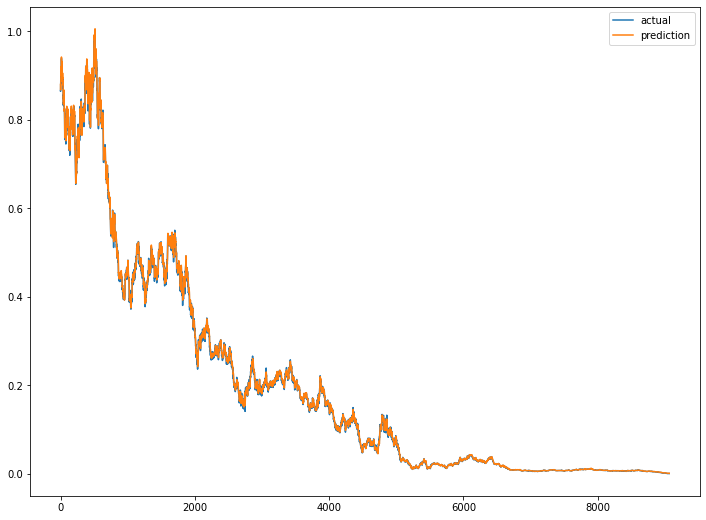

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 9))
plt.plot(test_label, label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()